# CO2 Intensity Forecasting

![co2_banner](img/co2_banner.jpg)

The energy industry faces an unprecedented challenge. There is an urgent need to reduce CO2 emissions and mitigate climate change. In this context, the shift towards energy efficient and flexible production is becoming increasingly important. Effectively addressing these challenges requires innovative approaches that go beyond traditional forecasting methods. This is where AI can help.

The use of an AI tool to predict CO2 levels represents a significant added value for energy efficient and energy flexible manufacturing. By integrating AI into the energy industry, companies can make more accurate predictions and optimise their energy production while minimising their CO2 emissions. This enables manufacturing companies to respond flexibly to fluctuations in energy production and demand, and to optimise the use of energy sources with low CO2 emissions.

In this notebook, a gradient boosting model is trained using historical energy and CO2 data. By training the model with historical data, it learns to recognise patterns and correlations in the input data and to make a CO2 prediction over a 48-hour period.

It is recommended to read the notebook regarding the day-ahead price first.

In [1]:
# Import libraries

# Self-written utilites
from ADP_EPF.data import *
from ADP_EPF.models import *
from ADP_EPF.evaluation import *
from ADP_EPF.scaler import *

# XGBoost model
import xgboost as xgb

# Data acquisition
from entsoe import EntsoePandasClient

# Standard data science libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get CO2 and Energy Data
CO2 intensities are generated using Tobias Kapser's tool. This tool uses historical data for different types of energy production and calculates the average CO2 emissions per kWh using assigned CO2 factors. The energy data are obtained from ENTSO-E.

The ENTSO-E Transparency Platform is a valuable resource for accessing and analyzing energy data from the European Network of Transmission System Operators for Electricity (ENTSO-E). This platform provides a centralized hub for real-time and historical information related to electricity transmission across Europe. By utilizing the ENTSO-E API, we can access a wide range of data, enabling them to perform comprehensive analysis, build forecasting models, and gain insights into the European energy market. To be able to use the API, an API key needs to be requested from ENTOS-E by emailing the following address: transparency@entsoe.eu

In [3]:
df_CO2 = read_co2_csv('data/CO2_equivalents_DE-LU_1h.csv')

In [4]:
print(f'The CO2 data has {len(df_CO2[df_CO2.eq(0).any(axis=1)])} values that euqal zero.')

The CO2 data has 7 values that euqal zero.


The CO2 data has 7 Values that equal zero. As renewable energies also have low CO2 emissions, these values can only be calculation errors. The following function therefore interpolates the error points. This is done by simply taking the average of the previous and subsequent values.

In [4]:
df_CO2 = interpolate_zeros(df_CO2)

In [5]:
df_CO2.head()

CO2
2020-01-01 01:00:00+01:00  476.513345
2020-01-01 02:00:00+01:00  469.555833
2020-01-01 03:00:00+01:00  462.102077
2020-01-01 04:00:00+01:00  463.953946
2020-01-01 05:00:00+01:00  463.469072

The CO2 data was calculated for the period between the 1st january 2020 and the 30th June 2023.

In [6]:
df_CO2.tail()

CO2
2023-06-30 19:00:00+02:00  480.889580
2023-06-30 20:00:00+02:00  558.636512
2023-06-30 21:00:00+02:00  622.729601
2023-06-30 22:00:00+02:00  659.715219
2023-06-30 23:00:00+02:00  664.247746

In [7]:
############ enter your API key ###############
api_key='ENTSOE_API_KEY'
###############################################

# df = get_train_data(client = EntsoePandasClient(api_key))

# df.to_csv('data/train_data.csv')

Downloading energy data from ENTSO-E can take a few minutes. Therefore, this data is also available as a CSV file. This CSV can be imported with the following lines of code.

In [6]:
df = pd.read_csv('data/train_data.csv', index_col=0)
df.index = pd.to_datetime(df.index, utc=True)
df.index = df.index.tz_convert('Europe/Brussels')

In [7]:
df.head()

Day-Ahead Price [€/MWh]  \
2016-01-01 00:00:00+01:00                    23.86   
2016-01-01 01:00:00+01:00                    22.39   
2016-01-01 02:00:00+01:00                    20.59   
2016-01-01 03:00:00+01:00                    16.81   
2016-01-01 04:00:00+01:00                    17.41   

                           Forecasted Load [summed up MW]  \
2016-01-01 00:00:00+01:00                        186864.0   
2016-01-01 01:00:00+01:00                        177664.0   
2016-01-01 02:00:00+01:00                        171406.0   
2016-01-01 03:00:00+01:00                        169234.0   
2016-01-01 04:00:00+01:00                        169488.0   

                           Forecasted Renewable Generation [summed up MW]  
2016-01-01 00:00:00+01:00                                         33118.0  
2016-01-01 01:00:00+01:00                                         32575.0  
2016-01-01 02:00:00+01:00                                         31587.0  
2016-01-01 03:00:00+01:00                                         30559.0  
2016-01-01 04:00:00+01:00                                         29199.0

The API loads the Day-Ahead Price, Load Forecast and Renewable Energy Forecast over a period from 1st January 2016 to 31st May 2023. The Renewable Energy Forecast and the Load Forecast are crucial data in the European electricity market. The Renewable Energy Forecast forecasts renewable energy production, while the Load Forecast forecasts future electricity demand. Both forecasts are based on data such as weather models and historical energy production and consumption data. These forecasts play an important role in price formation by helping market participants to adjust their offers and avoid congestion. The data for the forecasts is updated and made available on a regular basis. As both data are already a forecast, they facilitate the training of the model as only a short period of time needs to be forecast.

Energy data is available for each quarter of an hour as output in MW. The load forecast and the renewable energy forecast are not averaged over an hour or calculated as energy in MWh, but added together. This has led to better results over the course of the project.

In [10]:
df.tail()

Day-Ahead Price [€/MWh]  \
2023-06-30 19:00:00+02:00                   117.96   
2023-06-30 20:00:00+02:00                   133.43   
2023-06-30 21:00:00+02:00                   130.74   
2023-06-30 22:00:00+02:00                   122.39   
2023-06-30 23:00:00+02:00                   109.47   

                           Forecasted Load [summed up MW]  \
2023-06-30 19:00:00+02:00                        224109.0   
2023-06-30 20:00:00+02:00                        214970.0   
2023-06-30 21:00:00+02:00                        205901.0   
2023-06-30 22:00:00+02:00                        198260.0   
2023-06-30 23:00:00+02:00                        185426.0   

                           Forecasted Renewable Generation [summed up MW]  
2023-06-30 19:00:00+02:00                                         35579.0  
2023-06-30 20:00:00+02:00                                         19282.0  
2023-06-30 21:00:00+02:00                                         12673.0  
2023-06-30 22:00:00+02:00                                         13423.0  
2023-06-30 23:00:00+02:00                                         16842.0

# Data Understanding

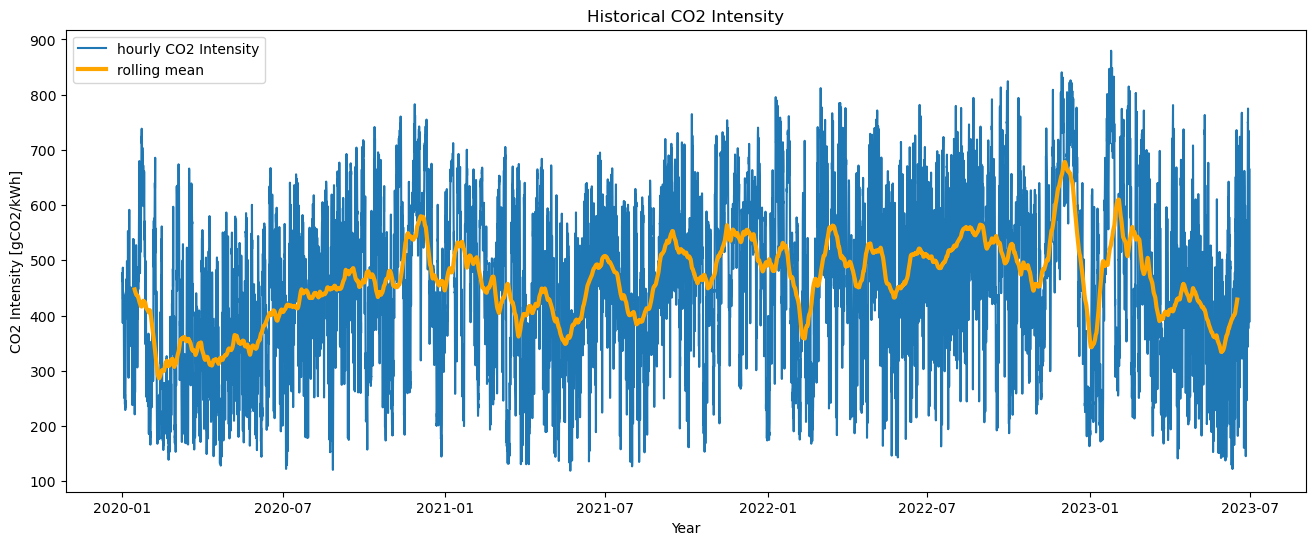

In [11]:
plt.figure(figsize=(16,6))
plt.plot(df_CO2, label='hourly CO2 Intensity')
plt.plot(df_CO2.rolling(24*7*4, center=True).mean(), label='rolling mean', color='orange', linewidth=3)
plt.legend()
plt.xlabel('Year')
plt.ylabel('CO2 Intensity [gCO2/kWh]')
plt.title('Historical CO2 Intensity')
plt.show()

If we look at CO2 emissions per kWh over the last few years, we see that they have not decreased. On the contrary, CO2 emissions have increased slightly. In 2022, there is even a fairly large increase. CO2 emissions in 2022 are more than 90 gCO2/kWh higher than in 2020.

In [12]:
df_CO2.groupby(df_CO2.index.year).describe()

CO2                                                              \
       count        mean         std         min         25%         50%   
2020  8783.0  410.962314  144.480602  120.500940  292.628192  410.623636   
2021  8760.0  465.990212  140.554008  118.934863  365.907740  482.385137   
2022  8760.0  504.952734  151.946319  143.038166  395.816821  515.563190   
2023  4343.0  446.710693  169.306438  122.029180  315.012338  429.083737   

                              
             75%         max  
2020  518.513133  782.603612  
2021  577.954720  764.701137  
2022  626.880792  840.429318  
2023  571.125010  879.550764

# Feature Engineering
The forecasting model is not trained on the raw data, but on features that can better reflect the characteristics of a time series. Therefore, in the following, different lag features are generated from the downloaded data.

Lag features, also known as delayed features, play a crucial role in predicting time series. These features represent past observations or values of a time series and serve as input to the AI model. By incorporating lag features into the model, it becomes possible to capture past patterns and trends to make accurate predictions for future values. 

In a 2021 paper on best practices in energy price forecasting, Lago et al. describe a dataset of lagged features that is also used in this notebook. However, only data between 9th January 2012 and 31st December 2017 were used in that paper (Lago et al., 2021). Therefore, a function was written to reconstruct these features in order to use more recent data to train the model.

In [13]:
X = create_features(df)

Once the features have been created, the target is calculated using the following function. The feature dataframe is required to perform an index match. This ensures that all data series are present in both data frames. Unlike the price model, the CO2 model forecasts over a 48-hour period.

In [14]:
y, X = create_co2_target(df_CO2, X)

# Number of hours to look into the future
y.shape[1]

48

# CO2 Forecasting Model
In the following, we will train an XGBoost (Extreme Gradient Boosting) model. This model is a powerful and widely used machine learning algorithm known for its exceptional predictive performance. It belongs to the family of boosting algorithms, which are ensemble learning techniques that combine multiple weak models to create a strong predictive model.

The algorithm uses decision trees as the base learners or weak models. Decision trees are simple yet powerful models that learn hierarchical rules and make predictions by traversing a tree-like structure. XGBoost adapts decision trees to optimize the objective function efficiently, making it suitable for both regression and classification tasks.

XGBoost has been successfully applied in various domains and machine learning tasks. It has consistently delivered top-performing solutions in industry competitions, such as the Kaggle data science competitions. With its effectiveness in regression, classification, ranking, and recommendation systems, XGBoost has become a popular choice for both academic research and real-world applications. As in the day-ahead price notebook, training data from 2020 to 2022 are used. The data from 2023 is used as test data.

In [21]:
X_train = X.loc[X.index.year.isin([2020, 2021, 2022])]
y_train = y.loc[y.index.year.isin([2020, 2021, 2022])]

X_test = X.loc[X.index.year.isin([2023])]
y_test = y.loc[y.index.year.isin([2023])]

If the hyperparameter option is false, only a model with 500 estimators is trained. If the option is True, a random grid search is used to optimise the number of estimators and the maximum depth of each decision tree. To do this, the training data is split into five parts with a time series split and 20 iterations are calculated for each split. The calculated model is then stored in the best_models directory. The exact procedure of the function can be found in the models.py file.

In [24]:
model_CO2 = fit_xgb_model(X_train, y_train, hyperparameter = False)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Since hyperparametertuning has a high computational cost, the option should either be Flase or an already optimised model should be loaded with the following lines of code.

In [26]:
model_CO2 = xgb.XGBRegressor()
model_CO2.load_model('best_models/xgb_co2_model_20230724052125.txt')

The metrics used are mean absolute error (MAE), root mean squared error (RMSE) and semtric mean absolute percentrige error (sMAPE). The sMAPE is particularly useful for assessing the performance of the model over changing average CO2 Intenisites. It is a widely used metric for evaluating forecast accuracy. The sMAPE provides a symmetric measure that considers both overestimations and underestimations of CO2 Intensity, which is crucial in this domain. Being a percentage-based metric, it enables easy comparability, while also being robust against extreme values.

In [27]:
prediction = model_CO2.predict(X_test)
model_evaluation(p_real=y_test, p_pred=prediction)

MAE on test set: 64.94
RMSE on test set: 78.84
sMAPE on test set: 15.51


To give an overview of the best and worst weeks of the test period, the indexes of the best and worst three weeks are calculated.

In [28]:
error = np.abs(y_test - prediction).mean(axis=1)
error.resample('W-Mon').mean().sort_values(ascending=False).head(5)

2023-01-23    97.795630
2023-01-30    90.009407
2023-02-13    81.453411
2023-02-20    79.036906
2023-02-06    74.771640
dtype: float64

In [29]:
error.resample('W-Mon').mean().sort_values().head(5)

2023-05-08    43.041830
2023-01-02    47.492093
2023-06-12    48.478831
2023-05-29    48.859740
2023-03-20    49.716690
dtype: float64

The plots show that the model has difficulty in predicting particularly high CO2 emissions. Nevertheless, the model is able to reconstruct the general course of CO2 emissions well.

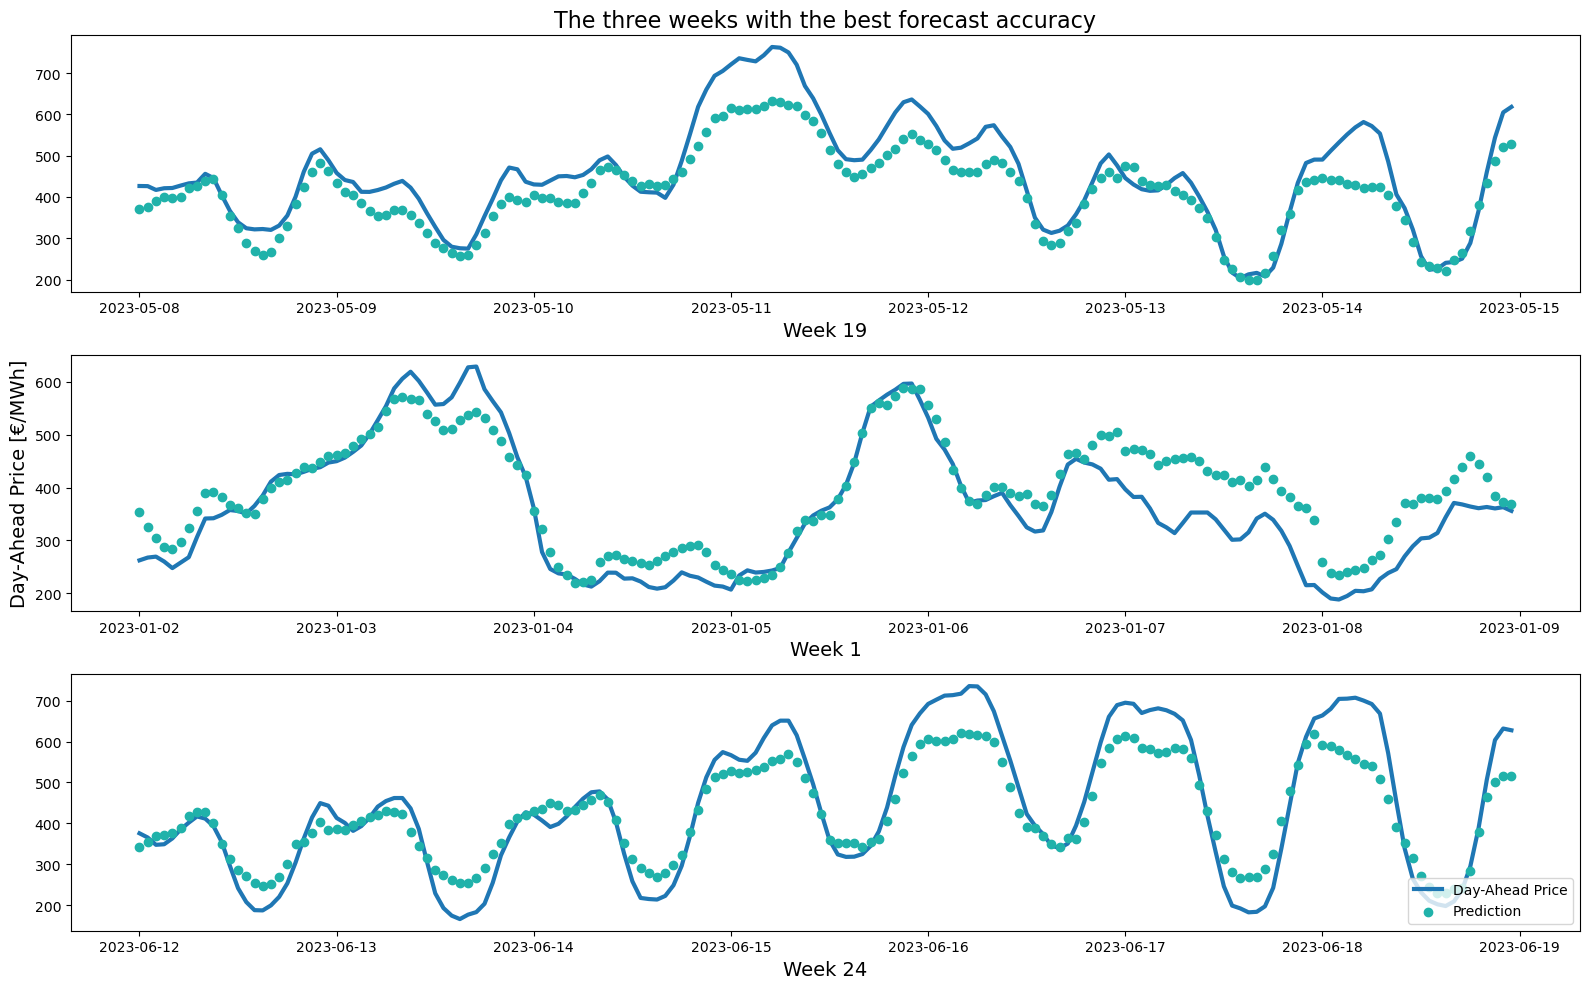

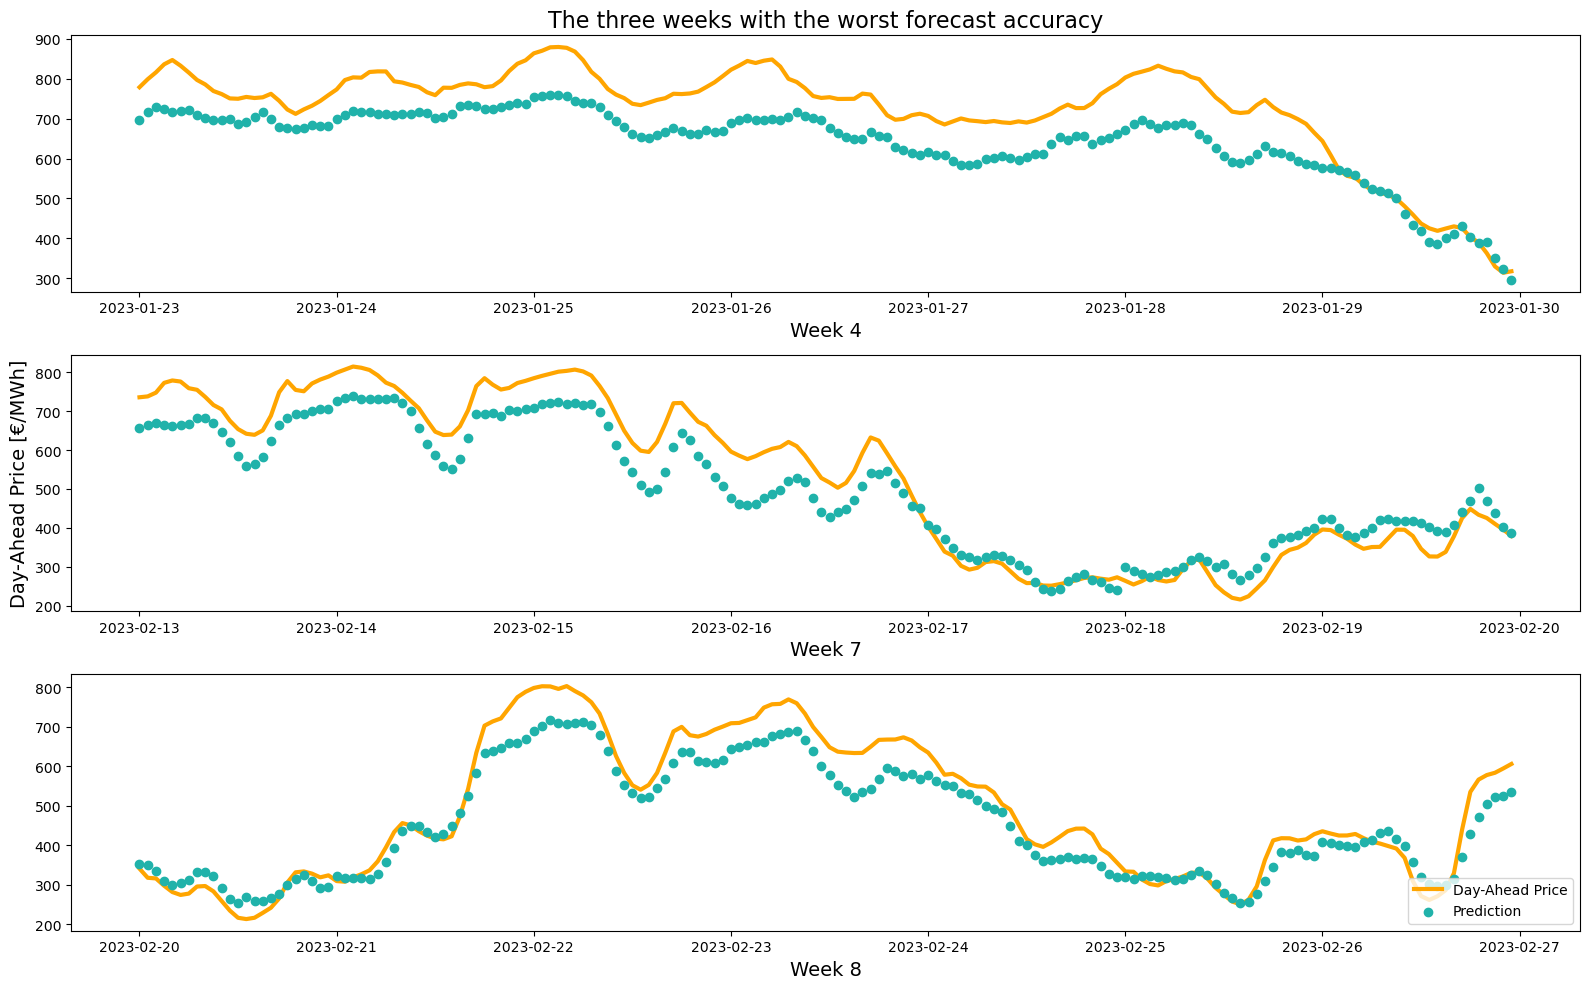

In [30]:
plot_price_forecast_weeks(y_test=y_test, prediction=prediction, best_weeks=True, worst_weeks=True)

# LSTM Model

In addition to gradient boosting models, Long Short Term Memory (LSTM) models have also been investigated and are discussed below.

LSTM models are a special type of recurrent neural network (RNN) that are well suited to time series prediction. LSTM models are characterised by their ability to capture long dependencies in a time series by using internal memory cells. These internal memory cells allow LSTM models to effectively store and access past information to make accurate predictions for the future. This capability makes LSTM models particularly well suited to predicting time series where past observations can have a strong influence on future values. 

A disadvantage of LSTM models is their high computational complexity, especially when processing large datasets, which can lead to longer training times. In addition, LSTM models can be prone to overfitting, especially if the network architecture is not properly tuned.

In [31]:
y_lstm = df_CO2.loc[df_CO2.index.year.isin([2020, 2021, 2022, 2023])]
X_lstm = df.loc[df.index.year.isin([2020, 2021, 2022, 2023])]

y_lstm = y_lstm[y_lstm.index.isin(X_lstm.index)]
X_lstm = X_lstm[X_lstm.index.isin(y_lstm.index)]

len(y_lstm) == len(X_lstm)

True

In [32]:
df_lstm = y_lstm.join(X_lstm)

In [33]:
# Converte the datafraem into a numpy array
array_lstm = df_lstm.loc[df_lstm.index.year.isin([2020, 2021, 2022])].to_numpy()

In [34]:
# Calculate the min and max values for scaling the training data
train_min_val = np.min(array_lstm, axis=0)
train_max_val = np.max(array_lstm, axis=0)

# Days to look in the future and past
n_future = 24*2
n_past = 24*3

First, the data must be scaled, as the activation functions of the LSTM model can be sensitive to values that are far apart or particularly high. This step was not necessary with the previous XGBoost model. A min-max-scaling is selected as the scaling mode. Care must be taken to ensure that no information is transferred from the test data set to the training data set. Therefore, the extremes are only determined for the training data set. All data sets are scaled based on these extreme values.

In [35]:
array_scalded = min_max_scaler(array_lstm, min_val=train_min_val, max_val=train_max_val)

Unlike the lag features in the XGBoost model, the LSTM model defines rolling windows. These data windows capture 3 days of raw data from the past, which is the input to the model. The output of the LSTM model is the next 24 hours, just like the previous model. The rolling window is shifted by one hour each time. The idea is that the LSTM model, through its internal long-term memory, is able to recognise and learn patterns from the past data itself. 

In [36]:
X_train, y_train = WindowGenerator(array_scalded, n_future, n_past)

X shape == (26184, 72, 4).
Y shape == (26184, 48).


The next step is to train the LSTM model. Due to the many parameters within an LSTM neuron, training is much more complex than for gradient boosting models. 

In [28]:
lstm_model = fit_lstm_model(X_train, y_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 48)                1584      
                                                                 
Total params: 7,376
Trainable params: 7,376
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
655/655 [==============================] - 7s 9ms/step - loss: 0.1519 - val_loss: 0.1368
Epoch 2/100
655/655 [==============================] - 6s 9ms/step - loss: 0.1257 - val_loss: 0.1179
Epoch 3/100
655/655 [==============================] - 6s 9ms/step - loss: 0.1193 - val_loss: 0.1096
Epoch 4/100
655

To obtain a prediction, the test data set is also scaled and formatted as a rolling window. The prediction or output of the LSTM model is also scaled and needs to be backscaled for better interpretation and presentation of the results. The minimum and maximum values of the training data set are also used for this backscaling.

In [29]:
df_test = df_lstm.loc[df_lstm.index.year.isin([2023])].to_numpy()
df_test_scalded = min_max_scaler(df_test, min_val=train_min_val, max_val=train_max_val)
X_test, y_test = WindowGenerator(df_test_scalded, n_future, n_past)

prediction = lstm_model.predict(X_test)

prediction_inverse = inverse_min_max_scaler(prediction, min_val=train_min_val, max_val=train_max_val)
y_test_inverse = inverse_min_max_scaler(y_test, min_val=train_min_val, max_val=train_max_val)

X shape == (4224, 72, 4).
Y shape == (4224, 48).
132/132 [==============================] - 1s 3ms/step


In [30]:
prediction_inverse = inverse_min_max_scaler(prediction, min_val=train_min_val, max_val=train_max_val)
y_test_inverse = inverse_min_max_scaler(y_test, min_val=train_min_val, max_val=train_max_val)

The LSTM model does not match the accuracy of the XGBoost model. This is not necessarily due to the general ability of this AI model to predict time series. LSTM models have been shown many times in the past to be excellent forecasters. A disadvantage of this model, however, as mentioned above, is its high computational cost, which is why no hyperparameter tuning was performed as part of the ADP.

In [31]:
model_evaluation(p_real=y_test_inverse, p_pred=prediction_inverse)

MAE on test set: 92.83
RMSE on test set: 113.31
sMAPE on test set: 21.88
